# Calculating the largest Lyapunov Exponent using TensorFlow

* notice: too slow for practical use
* Tensorflow version: 1.14 

import

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time

from scipy.integrate import solve_ivp

Lorenz 方程式，Jacobian の定義

In [2]:
class Lorenz(object):
    """ defines Lorenz equation.
        dX/dt=f(X),
    where X = (x,y,z) is a three dimensional vector.
     arg:
        sigma,beta,rho : basic parameters of Lorenz equation
        x : A tensor of three dimensional state vector.
     returns:
      dX_dt : tensor of f(X)
    """
    def __init__(self, sigma=10., beta=8 / 3., rho=28., **kwargs):
        super().__init__(**kwargs)

        self.sigma = sigma
        self.beta = beta
        self.rho = rho

    def __call__(self, t, x):
        """ x here is [x, y, z] """
        # x = tf.cast(x, tf.float64)

        dx_dt = self.sigma * (x[1] - x[0])
        dy_dt = x[0] * (self.rho - x[2]) - x[1]
        dz_dt = x[0] * x[1] - self.beta * x[2]

        dX_dt = tf.stack([dx_dt, dy_dt, dz_dt])
        return dX_dt

In [3]:
def jacobian(t, f, x):
    """ return jacobian matrix of f at x"""
    n = x.shape[-1].value
    fx = f(t, x)
    if x.shape[-1].value != fx.shape[-1].value:
        print('For calculating Jacobian matrix',
              'dimensions of f(x) and x must be the same')
        return

    return tf.concat([tf.gradients(fx[i], x) for i in range(0, n)], 0)

元の常微分方程式とその軌道の周りに線形化した方程式 を同時に解くためのグラフ

In [4]:

def f_with_df(x_and_d, f, dim=3):
  """
    combine f and its differentiation Df (tensor)
     args:
        x_and_d: tensor of x and d. 2*dim dimension
        f: rhs of ode. f(x) have 3dim
        dim: dimension of x
  """
  x = x_and_d[0:dim]
  d = x_and_d[dim:2*dim]
  Df = jacobian(None, f, x)
  fx = f(None, x)
  Dfx_d = tf.linalg.matvec(Df, d)
  return tf.concat([fx, Dfx_d], 0)

与えられた区間で上記を使って2*d 次元の方程式を解く関数 (dはODEの次元)

In [5]:
def solve_f_with_df(sess, fx_and_df_x_d, x0_and_d0, ts):
    """ numerically solve ode defined by f
        and its linearized equation dot_d =  Df_x d
    """
    # wrapper function
    def fdf_tf(t, xd):
      return sess.run(fx_and_df_x_d, feed_dict={x_and_d: xd})

    sol = solve_ivp(fun=fdf_tf,
                    t_span=[ts[0], ts[-1]], y0=x0_and_d0, t_eval=ts)
    return sol['y'], sol['t']


delta を正規化する関数

In [6]:
def normalize_vec(d):
    norm = np.sqrt(np.sum(np.square(d)))
    newd= d/norm
    return norm,newd

## 変数の準備

In [7]:
tf.reset_default_graph()
dim = 3

# defining  parameters
rho = tf.Variable(28.0, dtype=tf.float64,
                    name='rho')
sigma = tf.Variable(10.0, dtype=tf.float64,
                      name='sigma')
beta = tf.Variable(8.0/3.0, dtype=tf.float64,
                     name='sigma')

f_lorenz = Lorenz(sigma=sigma, rho=rho, beta=beta)

# state variable x and its perturbation delta
x_and_d = tf.placeholder(dtype=tf.float64, shape=(dim*2), name='x_and_d')
# rhs f(x) and  Df(x)* d
f_df_x = f_with_df(x_and_d, f_lorenz)

# initial value
x0_d0 = np.array([-3.73, -5.76, 20.14, 0.5, 0.2, 0.2])


時間の設定

In [8]:
# integrating time
dt = 0.02
tstart = 0.0
tend =2000.0
ts = np.arange(tstart, tend+dt, dt)
len_t_sec = 10
nstep_t_sec = int( (len_t_sec/dt)+1)

t_sec = np.arange(tstart, tend, len_t_sec)

In [9]:
sess = tf.Session()
sess.run(tf.initializers.global_variables())

区間ごとに積分実行，xの軌道を保存，deltaの伸びを記録して正規化，

In [10]:
x_d = x0_d0.copy()  # intial condition
times = []
xs = []
norm_d_i = []

for i, t_i0 in enumerate(t_sec):
  ts_sec = t_i0 + dt* np.arange(0, nstep_t_sec)
  x_d_sec, _ = solve_f_with_df(sess, f_df_x, x_d, ts_sec)

  times.extend(ts_sec[0:-1])
  xs.extend(x_d_sec[0:dim, 0:-1].transpose())  # record x
  # normalize d and record its stretch
  norm, newd = normalize_vec(x_d_sec[dim:2*dim, -1])
  norm_d_i.append(norm)
  # update x and d
  x_d[0:dim] = x_d_sec[0:dim, -1]
  x_d[dim:2*dim] = newd

時刻ごとのLyapunov指数の推定値の計算

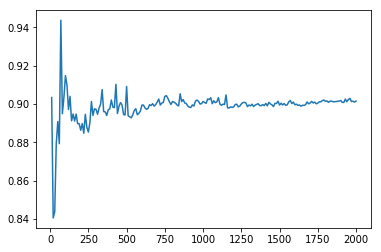

estimation of the largest Lyapunov exponent: 0.9015374472045383


In [11]:
# cast to numpy array
xs = np.array(xs)
times = np.array(times)
norm_d_i = np.array(norm_d_i)

lognorm_i = np.log(norm_d_i)
t_sec_l = t_sec + len_t_sec

lyap_t = np.cumsum(lognorm_i) / (t_sec_l)
plt.plot(t_sec_l, lyap_t)
plt.pause(0.001)
print('estimation of the largest Lyapunov exponent: {}'.format(lyap_t[-1]))
sess.close()
